In [34]:
import numpy as np
import cvxopt
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import matplotlib.cm as cmx
import matplotlib.colors as colors

In [40]:
del_t = 0.1
v_init = 10
w_init = 0.1
a_max = 10
alpha_min = -0.5
alpha_max = 0.5

class agent:
    def __init__(self,rad,start,goal,theta,vmax,wmax):
        self.rad = rad
        self.xpath = []
        self.ypath = []
        self.vplot = []
        self.wplot = []
        self.time = 0
        self.goal = goal
        self.theta = theta
        self.v = v_init
        self.w = w_init
        self.pos = start
        self.vmax = vmax
        self.wmax = wmax
        
    def __str__(self):
        return (str(self.time)+" "+str(self.theta)+" "+str(self.v)+" "+str(self.w)+" "+str(self.pos))    
            

    def opt_traj(self):
        self.visualize_traj()
        print ("start v: ",self.v,"start w: ",self.w)
        while (np.linalg.norm(self.pos-self.goal)>0.5):
            x_new = self.pos[0] + self.v*del_t*np.cos(self.theta+self.w*del_t)
            y_new = self.pos[1] + self.v*del_t*np.sin(self.theta+self.w*del_t)
            self.theta += self.w*del_t
            self.xpath.append(x_new)
            self.ypath.append(y_new)
            self.pos = [x_new,y_new]
            theta_new = self.theta
            v_new = self.v
            w_new = self.w
            diff_v = 999
            diff_w = 999
#             xgi = self.pos[0]
#             ygi = self.pos[1]
            tol = 1e-4
            while (np.linalg.norm(np.array([diff_w,diff_v])**2)>tol):
                # vi = self.v, wi = self.w
#                 theta_new += self.w*del_t
#                 xgi += (self.v*del_t*np.cos(theta_new) - self.goal[0])
#                 ygi += (self.v*del_t*np.sin(theta_new) - self.goal[1])
                w_guess = 0.1
                v_guess = 10
                x = del_t*np.cos(self.theta+w_guess*del_t)
                a = -v_guess*del_t**2*np.sin(self.theta+w_guess*del_t)
                y = del_t*np.sin(self.theta+w_guess*del_t)
                b = v_guess*del_t**2*np.cos(self.theta+w_guess*del_t)
                kx = self.pos[0]+v_guess*del_t**2*w_guess*np.sin(self.theta+w_guess*del_t) - self.goal[0]
                ky = self.pos[1]-v_guess*del_t**2*w_guess*np.cos(self.theta+w_guess*del_t) - self.goal[1]
                arrx = np.array([[x],[a]])
                arry = np.array([[y],[b]])
                p_mat = 2*(np.matmul(arrx,arrx.T)+np.matmul(arry,arry.T))
                P = cvxopt.matrix(p_mat,tc='d')
                q_mat = 2*(kx*arrx+ky*arry)
                Q = cvxopt.matrix(q_mat,tc='d')
                g_mat = np.array([[0,-1],[-1,0],[1,0],[0,1]])
                h = cvxopt.matrix(np.array([self.wmax,0,self.vmax,self.wmax]),tc='d')
                g = cvxopt.matrix(g_mat,tc='d')
                sol = cvxopt.solvers.qp(P,Q,g,h,options={'show_progress': False})
                v_new = sol['x'][0] #vd
                w_new = sol['x'][1] #wd
                print ("Optimizer op:",v_new,w_new)
#                 print (v_new,w_new)
                diff_v = v_new - self.v
                diff_w = w_new - self.w
                self.v = v_new #vd+vi
                self.w = w_new #wd+wi
            print ("##########End of Optimization#############")
            print ("new v: ",self.v,"new w: ",self.w)
            print ("Opti complete")
#             self.vplot.append(self.v)
#             self.wplot.append(self.w)
            print (self)
            self.time+=1
            self.visualize_traj()

             
    def visualize_traj(self):
        figure = plt.figure()
#         print (self.pos)
        print ("I wanna rotate by: ",self.theta)
        ax = figure.add_subplot(1,1,1)
        robot = matplotlib.patches.Rectangle(
            (self.pos[0]-self.rad*np.sqrt(2)*np.cos(self.theta+np.pi/4),self.pos[1]-self.rad*np.sqrt(2)*np.sin(self.theta+np.pi/4)),
            height = self.rad*2,
            width = self.rad*2,
            angle = self.theta*180/np.pi,
            edgecolor='black',
            linewidth=1.0,
            animated=True,
            alpha=1,
            zorder=2)
        ax.add_patch(robot)
        name = 'data/snap%s.png'%str(self.time)
        ax.plot([self.goal[0]], [self.goal[1]], '*', color="red", markersize =15,linewidth=3.0)
        ax.plot(self.xpath,self.ypath,'b-')
        ax.set_aspect('equal')
        ax.set_xlim(-10.0, 100.0)
        ax.set_ylim(-10.0, 100.0)
        ax.set_xlabel(r'$x (m)$')
        ax.set_ylabel(r'$y (m)$')
        ax.grid(True)
        plt.savefig(name, dpi = 200)
        plt.cla()
        plt.close(figure)
        return figure
    


In [42]:
bot = agent(2,np.array([0,0]),np.array([50,50]),np.pi/2,20,0.5)
bot.opt_traj()

I wanna rotate by:  1.5707963267948966
start v:  10 start w:  0.1
Optimizer op: 19.99999941309601 -0.49999726264278316
Optimizer op: 19.99999941309601 -0.49999726264278316
##########End of Optimization#############
new v:  19.99999941309601 new w:  -0.49999726264278316
Opti complete
0 1.5807963267948966 19.99999941309601 -0.49999726264278316 [-0.009999833334166612, 0.9999500004166653]
I wanna rotate by:  1.5807963267948966
Optimizer op: 19.999999421241316 -0.49999687737523707
##########End of Optimization#############
new v:  19.999999421241316 new w:  -0.49999687737523707
Opti complete
1 1.5307966005306182 19.999999421241316 -0.49999687737523707 [0.06997828565860045, 2.998350176988111]
I wanna rotate by:  1.5307966005306182
Optimizer op: 19.999999427966127 -0.4999964529348857
##########End of Optimization#############
new v:  19.999999427966127 new w:  -0.4999964529348857
Opti complete
2 1.4807969127930944 19.999999427966127 -0.4999964529348857 [0.24973421159981307, 4.9902556907074604

Optimizer op: 19.999999952906922 0.4999995066704943
Optimizer op: 19.999999952906922 0.4999995066704943
##########End of Optimization#############
new v:  19.999999952906922 new w:  0.4999995066704943
Opti complete
27 0.43081861989330783 19.999999952906922 0.4999995066704943 [31.378737535735567, 40.67600828357736]
I wanna rotate by:  0.43081861989330783
Optimizer op: 19.999999938921125 -0.4999995227077757
Optimizer op: 19.999999938921125 -0.4999995227077757
##########End of Optimization#############
new v:  19.999999938921125 new w:  -0.4999995227077757
Opti complete
28 0.48081857056035726 19.999999938921125 -0.4999995227077757 [33.151970785188446, 41.60101845876332]
I wanna rotate by:  0.48081857056035726
Optimizer op: 19.99999994528663 0.4999994841933548
Optimizer op: 19.99999994528663 0.4999994841933548
##########End of Optimization#############
new v:  19.99999994528663 new w:  0.4999994841933548
Opti complete
29 0.4308186182895797 19.99999994528663 0.4999994841933548 [34.969219153

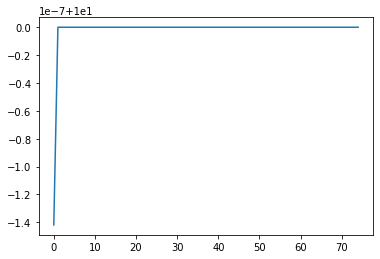

In [16]:
plt.plot(bot.vplot)

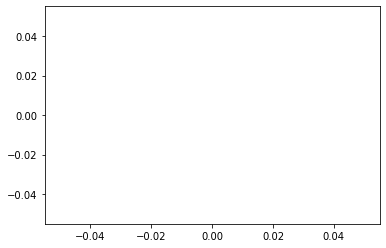

In [30]:
plt.plot(bot.wplot)

In [14]:
g = np.array([[3],[-5]])
print (np.matmul(g,g.T))

[[  9 -15]
 [-15  25]]
